# Google Colab Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1THgjI0PgP_iAXUhI-Xg__JMU-x3_X2LN)


## Mount Google Drive and Load CSV

Upload `PricePredictionCleanedUp.csv` to your Google Drive and set the path below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Update this path to your file location in Drive
csv_path = '/content/drive/MyDrive/PricePredictionCleanedUp.csv'


Mounted at /content/drive


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from xgboost import XGBRegressor
import joblib
import shutil

In [15]:
df = pd.read_csv(csv_path)
target_col = 'selling_price'
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

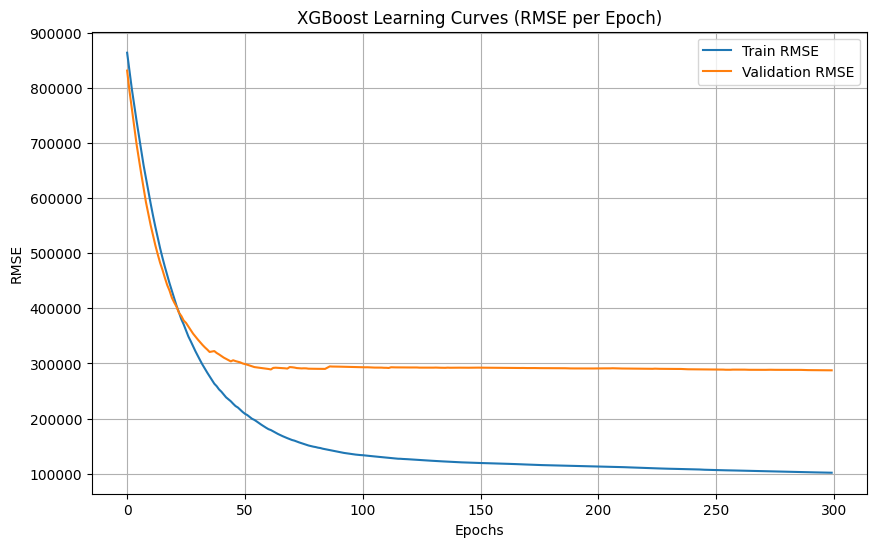

In [16]:
# Re-fit the model with eval_set to track performance metrics per epoch
# Note: For regression, we track RMSE instead of accuracy.

# Fix: In newer XGBoost versions, eval_metric is passed to the constructor or via set_params, not fit()
model.set_params(eval_metric='rmse')

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plotting Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation RMSE')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curves (RMSE per Epoch)')
plt.grid(True)
plt.show()

In [17]:
# Define the filename
model_filename = 'xgboost_price_model.pkl'

# 1. Save to the Runtime (Local Colab environment)
joblib.dump(model, model_filename)
print(f"Model saved locally to {model_filename}")

# 2. Save to Google Drive (as the Cloud storage)
# Note: This assumes Drive is mounted at /content/drive as per the top of the notebook
cloud_path = f'/content/drive/MyDrive/{model_filename}'
joblib.dump(model, cloud_path)
print(f"Model saved to Google Drive at {cloud_path}")

Model saved locally to xgboost_price_model.pkl
Model saved to Google Drive at /content/drive/MyDrive/xgboost_price_model.pkl


In [18]:
import numpy as np

metrics = {
    'train_mae': mean_absolute_error(y_train, train_pred),
    'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
    'train_r2': r2_score(y_train, train_pred),
    'test_mae': mean_absolute_error(y_test, test_pred),
    'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
    'test_r2': r2_score(y_test, test_pred),
}
metrics

{'train_mae': 69378.15625,
 'train_rmse': np.float64(101645.91340531109),
 'train_r2': 0.9872608780860901,
 'test_mae': 89995.9140625,
 'test_rmse': np.float64(287505.1820332983),
 'test_r2': 0.8901949524879456}

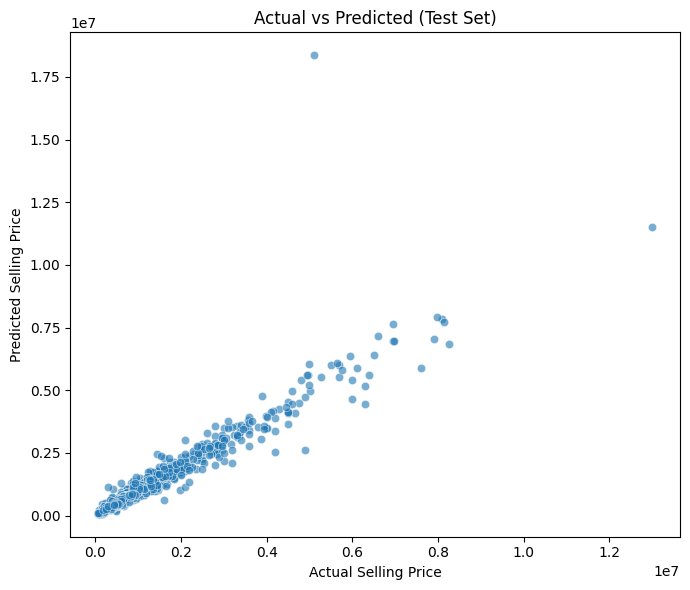

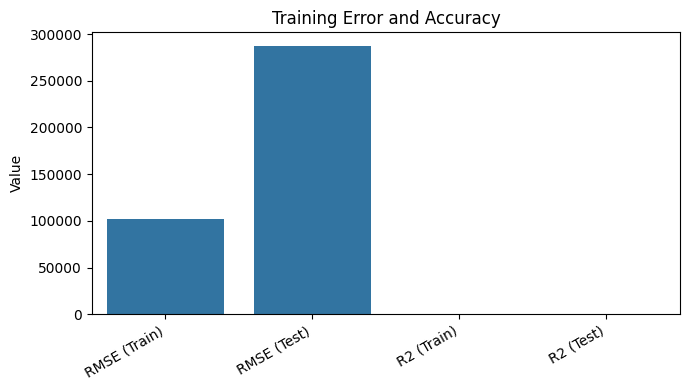

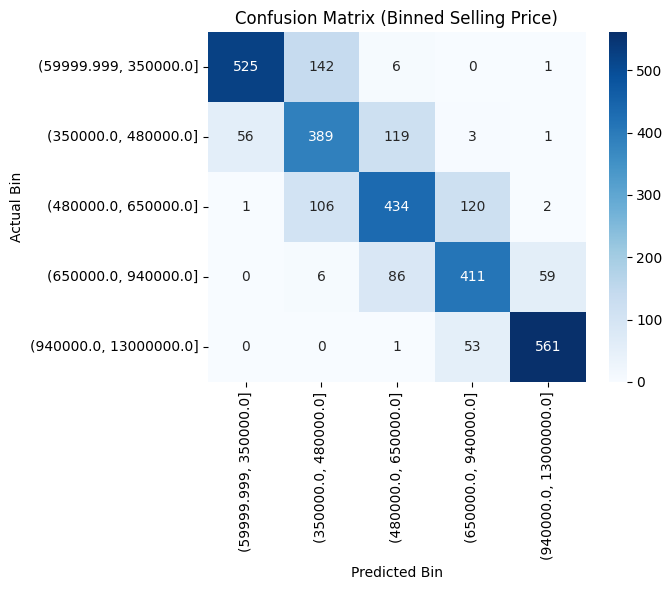

In [19]:
# Scatter plot: actual vs predicted
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=test_pred, alpha=0.6)
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted (Test Set)')
plt.tight_layout()
plt.show()

# Training error and accuracy summary
plt.figure(figsize=(7, 4))
metric_names = ['RMSE (Train)', 'RMSE (Test)', 'R2 (Train)', 'R2 (Test)']
metric_values = [
    metrics['train_rmse'],
    metrics['test_rmse'],
    metrics['train_r2'],
    metrics['test_r2'],
]
sns.barplot(x=metric_names, y=metric_values)
plt.ylabel('Value')
plt.title('Training Error and Accuracy')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Confusion matrix on binned targets (regression -> bins)
bins = pd.qcut(y_test, q=5, duplicates='drop')
bin_edges = bins.cat.categories

# Convert intervals to strings because sklearn doesn't support Interval objects
y_test_binned = bins.astype(str)
test_pred_binned = pd.cut(test_pred, bins=bin_edges, include_lowest=True).astype(str)
labels = bin_edges.astype(str)

cm = confusion_matrix(y_test_binned, test_pred_binned, labels=labels)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Binned Selling Price)')
plt.xlabel('Predicted Bin')
plt.ylabel('Actual Bin')
plt.tight_layout()
plt.show()

In [20]:
# Wähle eine Zeile aus den Testdaten (z.B. die erste Zeile)
sample_index = 0
sample_input = X_test.iloc[[sample_index]]
actual_value = y_test.iloc[sample_index]

# Mache eine Vorhersage
prediction = model.predict(sample_input)[0]

print(f"Beispiel Input (Index {sample_index}):")
display(sample_input)
print(f"\nTatsächlicher Verkaufspreis: {actual_value}")
print(f"Vorhergesagter Verkaufspreis: {prediction:.2f}")

Beispiel Input (Index 0):


,min_cost_price,max_cost_price,vehicle_age,km_driven,mileage,engine,max_power,seats,min_cost_price_z,max_cost_price_z,...,fuel_type_cat_id,fuel_type_freq,transmission_type_cat_id,transmission_type_freq,brand_char_len,brand_word_count,model_char_len,model_word_count,brand_model_char_len,brand_model_word_count
3334,698320.0,729333.3333,12,73000,20.36,1197,78.9,5,-0.091622,-0.426812,...,4,0.495944,1,0.793265,7,1,3,1,11,2



Tatsächlicher Verkaufspreis: 190000
Vorhergesagter Verkaufspreis: 228558.53


In [21]:
# Load the saved model
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

# Make inference using the loaded model
# sample_input is already defined in the previous cells
loaded_prediction = loaded_model.predict(sample_input)[0]

print(f"Prediction using loaded model: {loaded_prediction:.2f}")

Model loaded from xgboost_price_model.pkl
Prediction using loaded model: 228558.53
